In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 경로
data_dir = 'input/data/train'
image_dir = f'{data_dir}/images'
csv_path = f'{data_dir}/train.csv'

In [3]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

In [4]:
print(num2class)
print(class2num)

['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
{'incorrect_mask': 0, 'mask1': 1, 'mask2': 2, 'mask3': 3, 'mask4': 4, 'mask5': 5, 'normal': 6}


In [5]:
data = pd.read_csv(csv_path)
data.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [32]:
def get_img_stats(img_dir, img_paths):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_paths: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_path in tqdm(img_paths):
        for path in glob(os.path.join(img_dir, img_path, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0, 1)))
            img_info['stds'].append(img.std(axis=(0, 1)))
    return img_info

In [33]:
img_info = get_img_stats(image_dir, data.path.values[:])

In [18]:
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
imgs = []
img_id = data.iloc[200].path
for class_id in num2class:
    img = np.array(Image.open(os.path.join(image_dir, img_id, class_id+'.jpg')))
    imgs.append(img)
imgs = np.array(imgs)

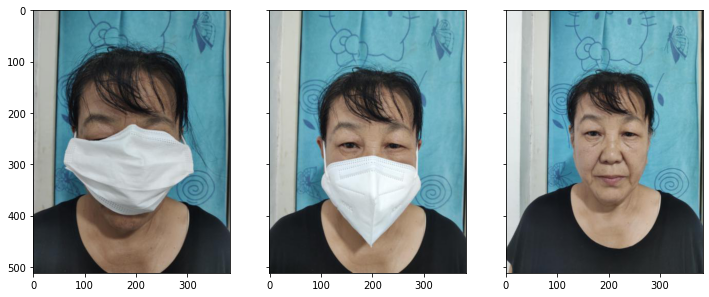

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

# 나이 분포와 성별 분포

female    1658
male      1042
Name: gender, dtype: int64


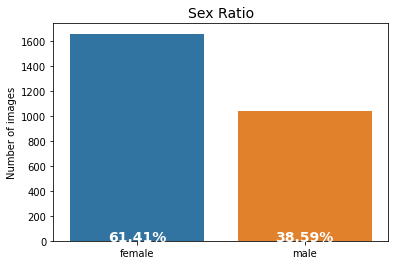

In [27]:
# y값 독립적 분포 확인
plt.figure()
ax = sns.countplot(x = 'gender', data = data)

plt.xticks(np.arange(2), ['female', 'male'])
plt.title('Sex Ratio', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = data['gender'].value_counts()
print(counts)
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color='w', fontweight = 'bold')
    
plt.show()

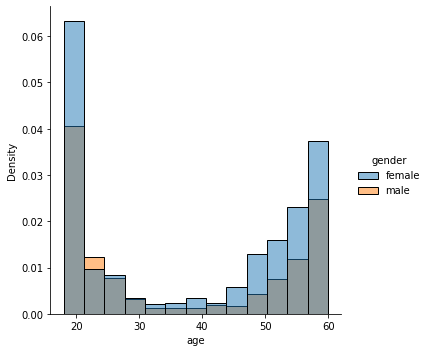

In [29]:
sns.displot(data, x='age', hue='gender', stat='density')
plt.show()

In [30]:
data['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

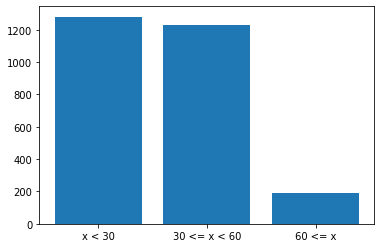

1281 1227 192


In [48]:
# 나이 분포
age_0 = data['age'][lambda x : x <30].count()
age_1 = data['age'][lambda x : (x >= 30) & (x<60)].count()
age_2 = data['age'][lambda x : x >= 60].count()
label = ['x < 30' , '30 <= x < 60', '60 <= x']
plt.figure()
plt.bar(label, [age_0, age_1, age_2])
plt.show()
print(age_0, age_1, age_2)

In [49]:
data.age.loc[data.age < 30] = 0
data.age.loc[(data.age >= 30) & (data.age < 60)] = 1
data.age.loc[data.age >= 60] = 2
data['age'].describe()

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

count    2700.000000
mean        0.596667
std         0.618886
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: age, dtype: float64

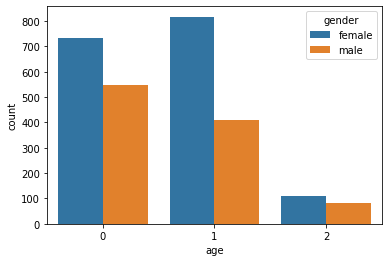

In [52]:
plt.figure()
sns.countplot(x='age',data=data,
              hue='gender')
plt.show()

# 데이터 이미지 확인 (노이즈 찾기)

In [98]:
def show_images(img_dir, idx):
    """
    마스크 미착용 이미지를 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        idx: 학습 데이터셋 인덱스
    """
    imgs = []
    img_id = data.iloc[idx].path
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(image_dir, img_id, class_id+'.jpg')))
        imgs.append(img)
    
    fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(16, 5))
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])
        axes[i].set_title(f'{num2class[i]}', color='r')
    fig.suptitle(f'{data.iloc[idx].id}, {data.iloc[idx].gender}, {data.iloc[idx].age}', fontsize=16)
    fig.tight_layout()
    plt.show()

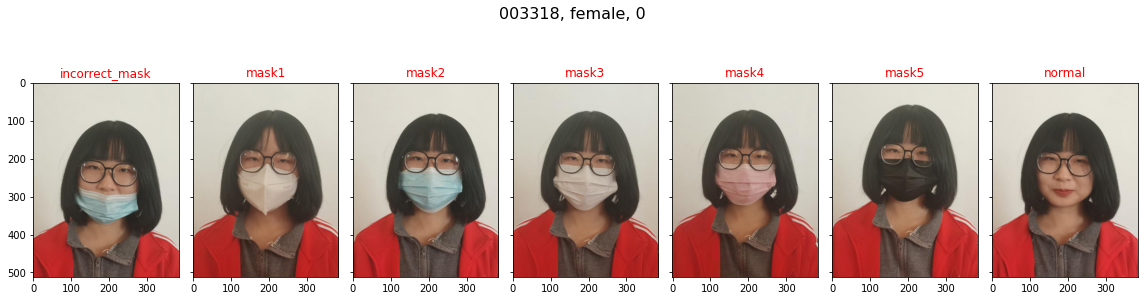

In [133]:
idx = 1301
show_images(image_dir, idx)

# PCA

In [99]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [139]:
start = 100
num = 200

imgs = []
for img_id in data.path.values[start:start+num]:
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(image_dir, img_id, class_id+'.jpg')).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape
print(n_samples)
imgs = np.reshape(imgs, (n_samples, h*w)) # 이미지에서 픽셀 밝기값을 일렬로 연결하여 벡터로 만듦

1400


벡터 데이터들을 가지고 PCA를 수행하면 데이터의 차원 수와 동일한 개수의 주성분 벡터들을 얻을 수 있다.   
이렇게 얻어진 주성분 벡터들을 다시 이미지로 해석한 것이 eigenface    
      
     
앞부분 eigenface들은 데이터들에 공통된 요소(얼굴의 전반적인 형태)를 나타내고 뒤로 갈수록 세부적인 차이 정보를 나타낸다.    
그리고 더 뒤로 가면 거의 노이즈(noise)성 정보를 나타낸다.    
k(n_componets)가 작아질수록 개인 고유의 얼굴 특성은 사라지고 공통의 얼굴 특성이 남게 된다

In [127]:
n_components = 20

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 9s
Explained variation per principal component: 
[0.21435224 0.12036052 0.08017683 0.04604297 0.04389526 0.03197381
 0.02062787 0.01748332 0.01670522 0.01277521 0.01104926 0.01066981
 0.01002825 0.00814761 0.00754278 0.00702122 0.006869   0.00610135
 0.00573764 0.00547068]


In [143]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')
pca_df.head(14)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,class_id
0,0.002538,-1.311903,1.909384,1.269160,0.105561,0.851370,1.783817,0.007006,-1.040318,-1.437391,...,0.455105,0.909827,-1.743258,0.747251,-0.615789,-0.003860,0.385690,0.812661,2.949679,incorrect_mask
1,1.028640,-1.088222,1.636204,-1.808924,-1.382080,0.495360,-0.359445,1.401339,-0.520629,0.832049,...,1.060179,-1.365930,-1.044734,-1.586448,-0.444219,-0.145869,0.112818,-0.648139,-0.275794,mask
2,0.426147,-0.938289,2.127527,0.486551,-0.827538,-1.084534,-2.096251,2.007337,2.373292,-0.430464,...,-0.351380,-0.020172,-2.007044,-0.372774,-1.229106,-0.178711,-1.504513,-0.486488,-0.372989,mask
3,0.748660,-1.354862,2.228932,1.469961,-0.955746,-0.905444,-0.549031,0.438954,2.294283,0.091202,...,-1.315220,0.849957,-2.560081,0.792818,-1.079572,0.634355,1.080077,-0.832480,0.345615,mask
4,0.311747,-1.147674,1.084467,0.478671,0.392078,1.107262,1.688602,0.335163,-0.081049,2.890889,...,-1.312103,-0.010275,0.518284,-0.551347,-0.909046,-0.071442,0.769680,-1.178364,0.845620,mask
5,0.555830,-1.452306,1.601192,-0.018308,-1.744280,-1.101599,-0.607628,0.195931,1.667001,1.386380,...,-0.867107,-0.662149,0.598874,-1.567186,-1.424104,0.151216,0.480276,-1.192858,0.114032,mask
6,-1.277415,-0.974891,1.732885,0.073086,-1.375138,-0.142385,0.954421,0.393131,-1.428568,0.211939,...,0.372874,-0.590841,-0.577892,-0.392287,0.122578,0.481391,2.185464,0.319517,-0.323750,normal
7,-0.144313,-0.722673,1.875702,-0.145215,-0.837654,0.056666,1.596227,-0.408819,-0.238857,0.297568,...,0.316051,0.492628,0.874722,0.066263,0.097295,-0.466246,0.631444,-0.327920,0.732374,incorrect_mask
8,0.842191,-1.027266,1.964933,-0.979695,-1.059382,0.721885,0.860361,0.444254,0.421651,-0.558934,...,0.677545,0.136835,0.924089,-0.442506,-0.367973,0.266777,-0.419716,-0.078544,0.874837,mask
9,0.410712,-0.944170,2.051004,0.080539,-0.537637,1.096121,1.557839,0.424211,-0.443897,-0.422782,...,0.227273,1.231774,-0.228548,0.498837,0.257705,-0.728448,0.787381,-0.007752,1.583836,mask


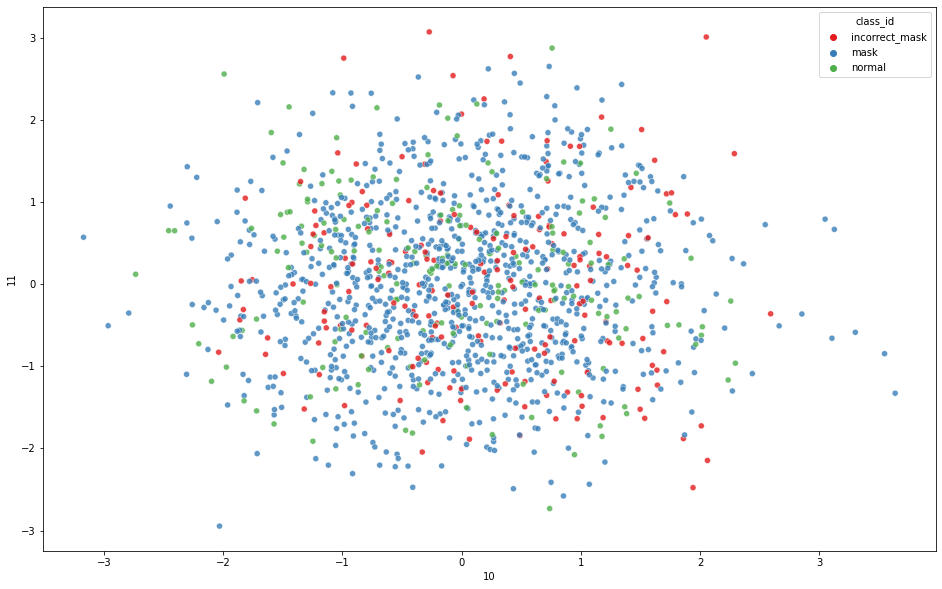

In [145]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='10', y='11',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set1", 3),
    alpha=0.8
)
plt.show()

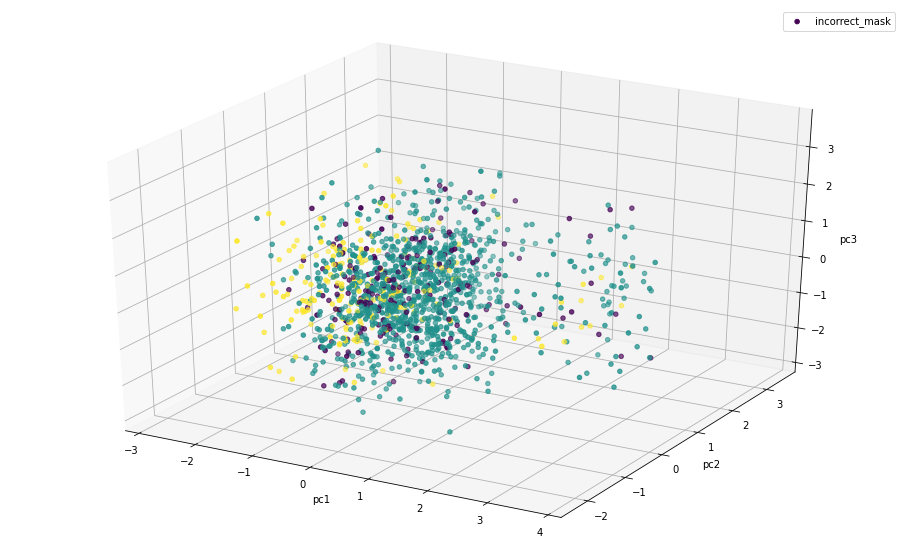

In [142]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"], 
    ys=pca_df["1"], 
    zs=pca_df["19"], 
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]), 
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [130]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1400 samples in 0.000s...
[t-SNE] Computed neighbors for 1400 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1400
[t-SNE] Computed conditional probabilities for sample 1400 / 1400
[t-SNE] Mean sigma: 1.734430
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.971275
[t-SNE] KL divergence after 300 iterations: 2.070107
t-SNE done! Time elapsed: 1.8398935794830322 seconds


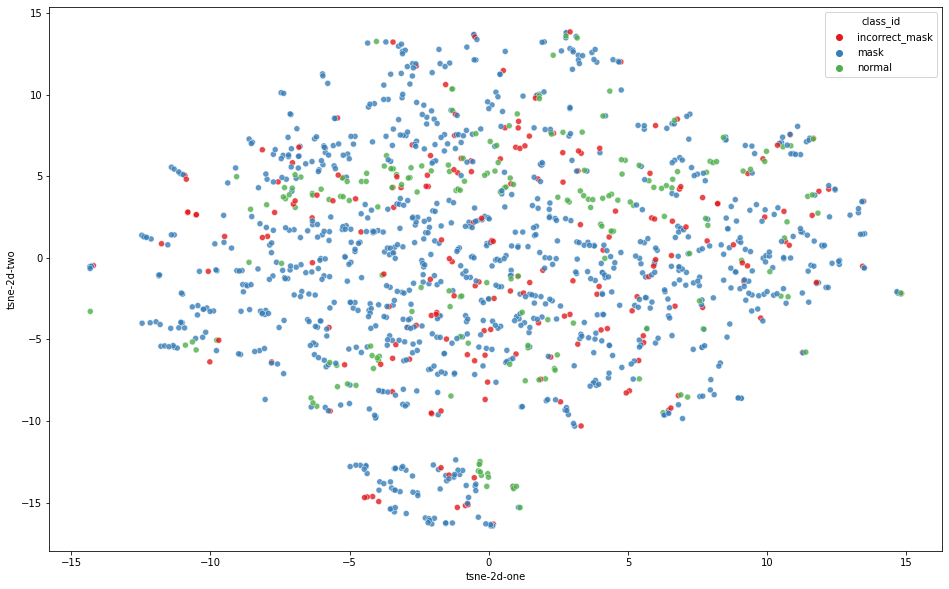

In [132]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set1", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()